# Look at the data

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



     |████████████████████████████████| 55 kB 430 kB/s 



     |████████████████████████████████| 8.2 MB 25.8 MB/s 







  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=7e39b48a433c4b958714b6aee985bd0259afacf1758528918e89192340b610cd

  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c

Successfully built docopt




[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.


Предварительно загрузим все данные на гугл диск, чтобы работать на мощностях Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
df = pd.read_csv('/content/drive/MyDrive/hse-nlp-bootcamp/train_ml.csv')
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54
3,vtb,Обращаюсь к Вам с жалобой на незаконное списан...,NaN,15.07.2020 14:54
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2.0,04.08.2020 6:38
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1.0,26.10.2016 11:03
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2.0,01.02.2020 21:07
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1.0,14.06.2016 16:03
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3.0,21.04.2020 8:24


# First EDA and Time Features Creating

Сразу видим, что в столбце с целевой переменной (`grades`) есть пропуски. Удалим просто строки с пропусками в целевой переменной (не будем ничего с ними придумывать).

Посмотрим предварительно еще, есть ли пропуски в признаках

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 75000 entries, 0 to 74999

Data columns (total 4 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   bank    75000 non-null  object 

 1   feeds   75000 non-null  object 

 2   grades  51476 non-null  float64

 3   date    75000 non-null  object 

dtypes: float64(1), object(3)

memory usage: 2.3+ MB


Сразу преобразуем столбец с меткой времени к соответствующему формату. И удалим строчки с пропусками в таргете

In [ ]:
df.dtypes

Unnamed: 0     int64
bank          object
feeds         object
grades         int64
date          object
lemmas        object
sym_len        int64
word_len       int64
dtype: object

In [27]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df.dropna()
df = df.astype({'grades': 'int32'})
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017-02-16 16:10:00
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016-12-13 01:05:00
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020-08-04 06:38:00
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00
8,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019-03-28 18:36:00
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1,2016-10-26 11:03:00
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020-02-01 21:07:00
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016-06-14 16:03:00
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020-04-21 08:24:00


Разберемся с фичами времени

*   Сделаем фичи Год, Месяц, День
*   А также фичу "время суток" из данных по часам и минутам (утро, день, вечер, ночь)



In [28]:
def time_day(hour):
  if 0 <= hour < 6:
    return 'night'
  elif 6 <= hour < 12:
    return 'morning'
  if 12 <= hour < 18:
    return 'afternoon'
  if 18 <= hour < 24:
    return 'evening'

In [29]:
df['year'] = df['date'].apply(lambda item: item.year)
df['month'] = df['date'].apply(lambda item: item.month)
df['day'] = df['date'].apply(lambda item: item.day)
df['time_day'] = df['date'].apply(lambda item: time_day(item.hour))

In [30]:
df

,bank,feeds,grades,date,year,month,day,time_day
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017-02-16 16:10:00,2017,2,16,afternoon
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016-12-13 01:05:00,2016,12,13,night
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020-08-04 06:38:00,2020,8,4,morning
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00,2015,4,19,evening
8,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019-03-28 18:36:00,2019,3,28,evening
...,...,...,...,...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1,2016-10-26 11:03:00,2016,10,26,morning
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020-02-01 21:07:00,2020,2,1,evening
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016-06-14 16:03:00,2016,6,14,afternoon
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020-04-21 08:24:00,2020,4,21,morning


Посмотрим на распределение числа отзывов по банкам

In [ ]:
feeds_by_bank_count = df.bank.value_counts()
feeds_by_bank_count

sberbank        8355
vtb             5255
tcs             4503
sovcombank      2600
fk_otkritie     2599
                ... 
sdm-bank          33
intesa            31
primsotsbank      31
rncb              30
rnbank            26
Name: bank, Length: 69, dtype: int64

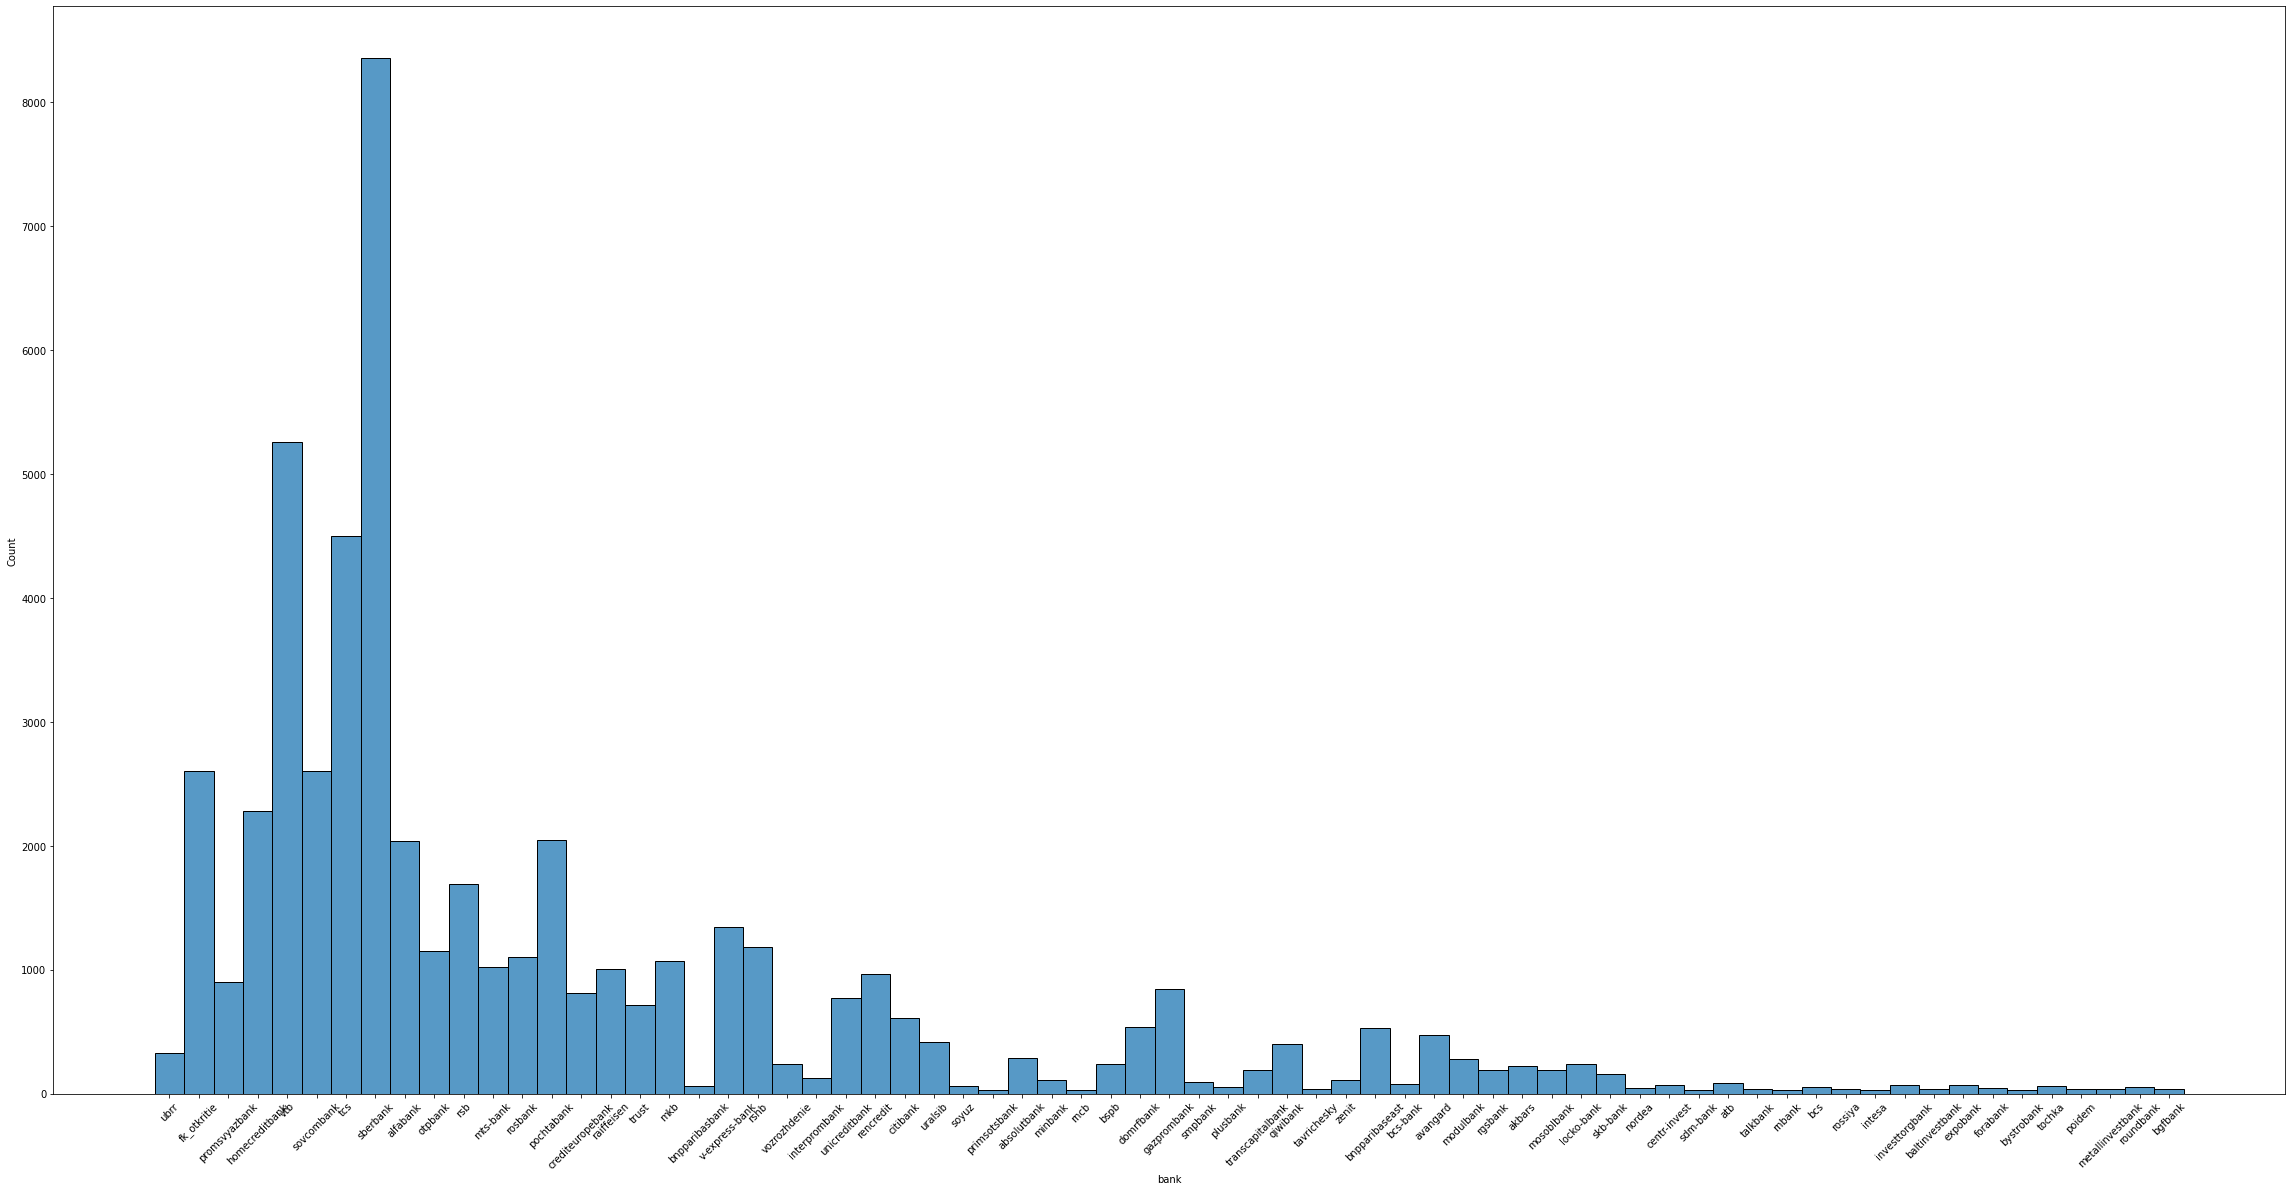

In [ ]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'), 
             x=df.bank, )
plt.xticks(rotation=45)
plt.show()

Глянем на распределение клиентских оценок

In [ ]:
df.grades.value_counts().sort_index()

1    27739
2     5634
3     2356
4     1520
5    14227
Name: grades, dtype: int64

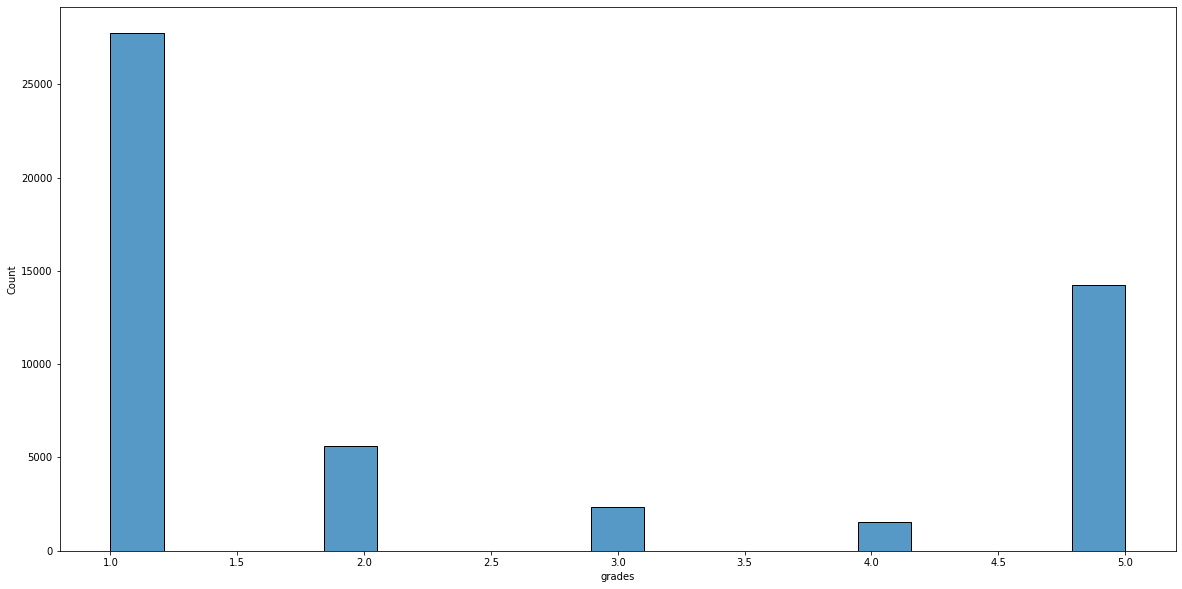

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, 
             x=df.grades, )
plt.show()

# Также нас интересуют длины отзывов

In [ ]:
df['sym_len'] = df.feeds.apply(len)
df['word_len'] = df.feeds.apply(lambda x: len(x.split()))

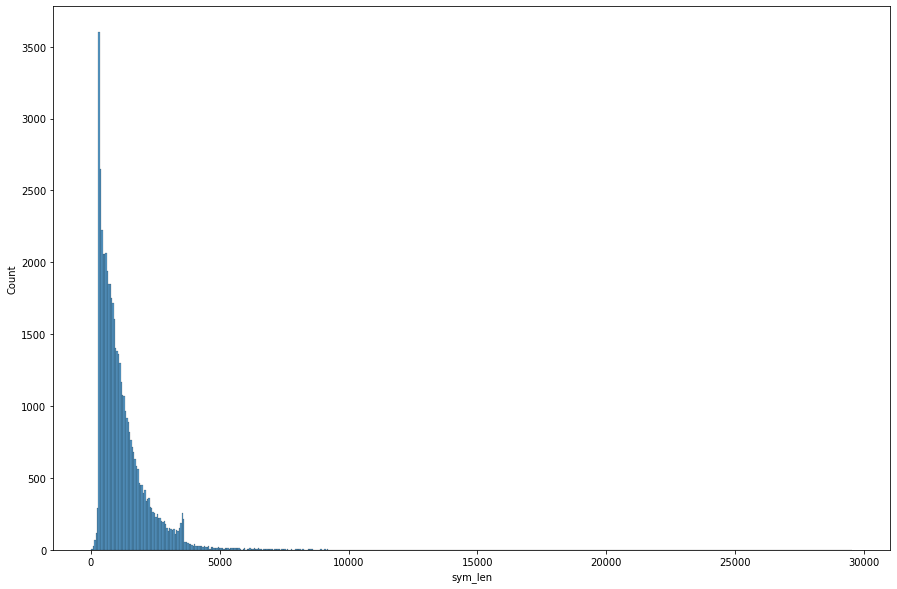

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.sym_len)
plt.show()

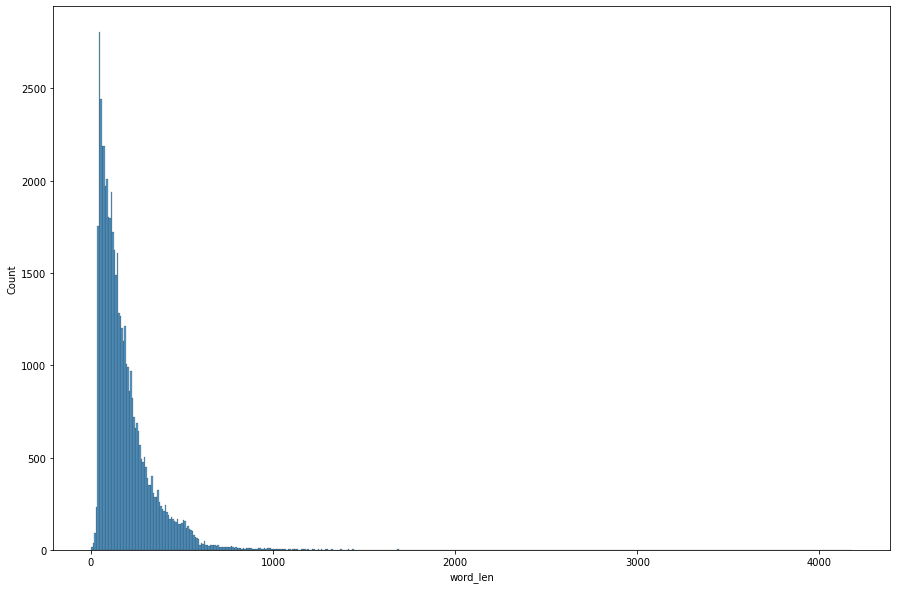

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.word_len)
plt.show()

Обратите внимание, у распределений очень длинные хвосты

Обратили, поэтому заведем логарифмированными эти фичи:

In [8]:
df['sym_len'] = np.log(df['sym_len'])
df['word_len'] = np.log(df['word_len'])

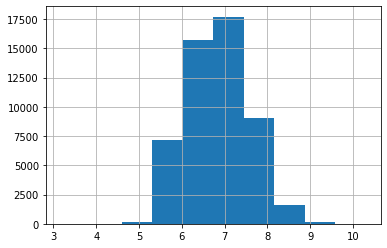

In [ ]:
df['sym_len'].hist()

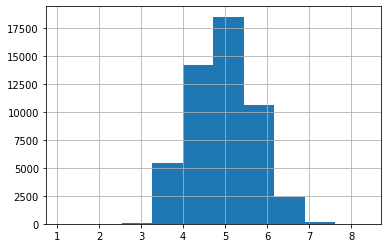

In [ ]:
df['word_len'].hist()

# Lemmas creating

Подготавливаем тексты отзывов

In [ ]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [ ]:
from multiprocessing import Pool as PoolSklearn
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df['feeds']), total=len(df)))
    
df['lemmas'] = lemmas
df.sample(5)

100%|██████████| 51476/51476 [23:59<00:00, 35.76it/s]


,bank,feeds,grades,date,lemmas
13059,crediteuropebank,Доброго времени суток. Хотелось бы понять один...,2,2014-06-16 21:17:00,добрый время сутки хотеться понять момент имен...
52081,pochtabank,"Самый худший банк, в котом когда-либо обслужив...",1,2020-07-11 16:50:00,самый плохой банк либо обслуживаться подать за...
45837,vozrozhdenie,"Речь пойдёт о Волжском филиале Банка ""Возрожде...",5,2006-10-24 09:25:00,речь пойда волжский филиал банк возрождение во...
65334,vtb,Я с мужем получаем зарплату на карту ВТБ с мая...,1,2018-03-27 09:37:00,получать зарплата карта недавно хотеть взять п...
69729,pochtabank,Получила предложение оформить кредитную карту ...,5,2016-08-05 14:26:00,получить предложение оформить кредитный карта ...


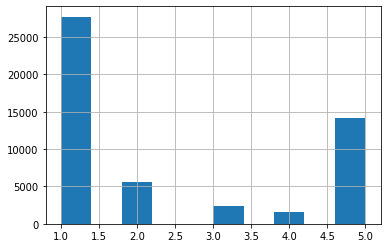

In [ ]:
df['grades'].hist()

In [ ]:
df['bank'].value_counts()

sberbank        8355
vtb             5255
tcs             4503
sovcombank      2600
fk_otkritie     2599
                ... 
sdm-bank          33
intesa            31
primsotsbank      31
rncb              30
rnbank            26
Name: bank, Length: 69, dtype: int64

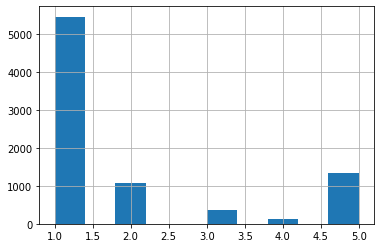

In [ ]:
df[df['bank']=='sberbank']['grades'].hist()

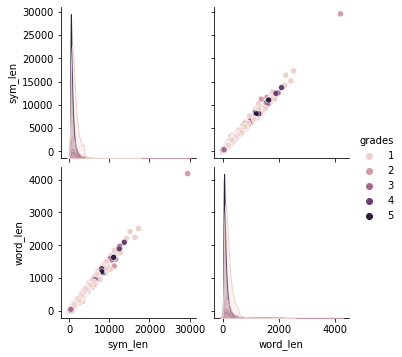

In [ ]:
import seaborn as sns
sns.pairplot(df, hue='grades')

# Pipeline. Catboost

Будем использовать catboost. В catboost встроен хороший обработчик текстовых фичей. Он проводит при желании все операции на GPU, что делает обучение очень быстрым.

In [9]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



     |████████████████████████████████| 76.6 MB 1.1 MB/s 

















In [11]:
from catboost import CatBoostClassifier
from catboost import Pool

#подбор параметров не включаю в ноутбук, чтобы не засорять. Оставлю только лучшую модель

def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=25000,
        learning_rate=0.009,
        eval_metric='MultiClass',
        #early_stopping_rounds=30,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [ ]:
df

,Unnamed: 0,bank,feeds,grades,date,lemmas,sym_len,word_len,year,month,day,time_day
0,0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017-02-16 16:10:00,являться клиент банк последний визит просто ос...,7.159292,5.283204,2017,2,16,afternoon
1,1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016-12-13 01:05:00,ростов ленин данный офис оказаться компетентны...,6.907755,5.062595,2016,12,13,night
2,2,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020-08-04 06:38:00,иметь потребительский кредит взять связь банк ...,7.386471,5.438079,2020,8,4,morning
3,3,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00,хотеть выразить глубокий благодарность весь со...,6.082219,3.970292,2015,4,19,evening
4,4,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019-03-28 18:36:00,март проход метро курский социальный карта бес...,7.069023,5.225747,2019,3,28,evening
...,...,...,...,...,...,...,...,...,...,...,...,...
51471,51471,trust,Три года длится эпопея с закрытием кредитной к...,1,2016-10-26 11:03:00,длиться эпопея закрытие кредитный карта получе...,6.333280,4.499810,2016,10,26,morning
51472,51472,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020-02-01 21:07:00,являться клиент бинбанка пока слияние перевест...,6.914731,5.010635,2020,2,1,evening
51473,51473,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016-06-14 16:03:00,вноситься деньга банковский карта visa сбербан...,7.109062,5.247024,2016,6,14,afternoon
51474,51474,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020-04-21 08:24:00,здравствуйте сегодня заходить мобильный банк п...,5.991465,4.043051,2020,4,21,morning


In [12]:
from sklearn.model_selection import train_test_split as tts
df.reset_index(drop=True, inplace=True)

df_train_val = df[['bank', 'feeds', 'lemmas', 'year', 'month', 'day', 'time_day', 'sym_len', 'word_len']]
y_train_val = df['grades']
X_train, X_val, y_train, y_val = tts(df_train_val, y_train_val, shuffle=True, stratify=y_train_val, train_size=0.8)  

In [13]:
train_pool = Pool(
    X_train, y_train, 
    cat_features=['bank', 'time_day', 'year', 'month', 'day'],
    text_features=['lemmas', 'feeds'],
)

validation_pool = Pool(
    X_val, y_val, 
    cat_features=['bank', 'time_day', 'year', 'month', 'day'],
    text_features=['lemmas', 'feeds'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

Train dataset shape: (41180, 9)



0:	learn: 1.5893202	test: 1.5892576	best: 1.5892576 (0)	total: 42.8ms	remaining: 17m 50s

100:	learn: 0.8762501	test: 0.8722101	best: 0.8722101 (100)	total: 2.21s	remaining: 9m 5s

200:	learn: 0.7368983	test: 0.7308984	best: 0.7308984 (200)	total: 4.25s	remaining: 8m 44s

300:	learn: 0.6921635	test: 0.6860262	best: 0.6860262 (300)	total: 6.24s	remaining: 8m 32s

400:	learn: 0.6717001	test: 0.6675702	best: 0.6675702 (400)	total: 8.25s	remaining: 8m 26s

500:	learn: 0.6601741	test: 0.6586947	best: 0.6586947 (500)	total: 10.2s	remaining: 8m 20s

600:	learn: 0.6534391	test: 0.6540049	best: 0.6540049 (600)	total: 12.1s	remaining: 8m 11s

700:	learn: 0.6481328	test: 0.6507631	best: 0.6507631 (700)	total: 14s	remaining: 8m 5s

800:	learn: 0.6437140	test: 0.6483421	best: 0.6483421 (800)	total: 15.9s	remaining: 7m 59s

900:	learn: 0.6396851	test: 0.6462836	best: 0.6462836 (900)	total: 17.7s	remaining: 7m 53s

1000:	learn: 0.6361808	test: 0.6446864	best: 0.6446

Построим график важности признаков при обучении catboost:

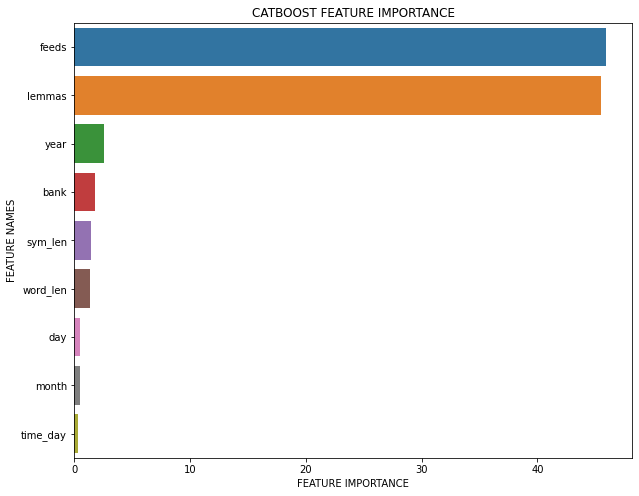

In [16]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#plot the catboost result
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST ')

Очевидно, фичи с текстом оказались сильно важны для обучения, добавление еще текстовых фичей, сгенерированных из этих, думаю, может помочь улучшить качество еще сильнее. Либо какие-то статистики со знаками препинания.

Посчитаем целевую метрику на валидации:

In [17]:
from sklearn.metrics import f1_score
val_preds = model.predict(validation_pool).flatten()
f1_score(val_preds, y_val, average='micro')

0.7945804195804196

Посмотрим на confusion matrix результатов. В принципе всё очевидно, многочисленные классы лучше предсказались

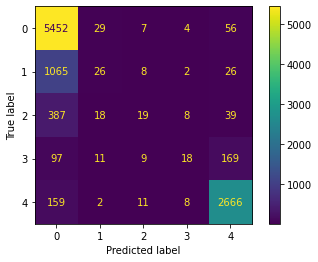

In [25]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

обучимся финально на почти всех имеющихся данных:

In [ ]:
from sklearn.model_selection import train_test_split as tts
df.reset_index(drop=True, inplace=True)

df_train_val = df[['bank', 'feeds', 'lemmas', 'year', 'month', 'day', 'time_day', 'sym_len', 'word_len']]
y_train_val = df['grades']
X_train, X_val, y_train, y_val = tts(df_train_val, y_train_val, shuffle=True, stratify=y_train_val, train_size=0.999)

In [ ]:
train_pool = Pool(
    X_train, y_train, 
    cat_features=['bank', 'time_day', 'year', 'month', 'day'],
    text_features=['lemmas', 'feeds'],
)

validation_pool = Pool(
    X_val, y_val, 
    cat_features=['bank', 'time_day', 'year', 'month', 'day'],
    text_features=['lemmas', 'feeds'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

Train dataset shape: (51424, 9)



0:	learn: 1.5892310	test: 1.5887971	best: 1.5887971 (0)	total: 44.5ms	remaining: 18m 31s

100:	learn: 0.8745153	test: 0.8727854	best: 0.8727854 (100)	total: 2.35s	remaining: 9m 40s

200:	learn: 0.7352007	test: 0.7275168	best: 0.7275168 (200)	total: 4.45s	remaining: 9m 8s

300:	learn: 0.6907276	test: 0.6747724	best: 0.6747724 (300)	total: 6.52s	remaining: 8m 55s

400:	learn: 0.6704396	test: 0.6489746	best: 0.6489746 (400)	total: 8.61s	remaining: 8m 48s

500:	learn: 0.6592787	test: 0.6353524	best: 0.6353524 (500)	total: 10.7s	remaining: 8m 44s

600:	learn: 0.6525412	test: 0.6304658	best: 0.6302524 (598)	total: 12.7s	remaining: 8m 35s

700:	learn: 0.6476338	test: 0.6275759	best: 0.6275759 (700)	total: 14.7s	remaining: 8m 28s

800:	learn: 0.6433278	test: 0.6244315	best: 0.6244315 (800)	total: 16.6s	remaining: 8m 22s

900:	learn: 0.6395207	test: 0.6224546	best: 0.6221883 (886)	total: 18.6s	remaining: 8m 18s

1000:	learn: 0.6360855	test: 0.6216493	best: 0.6

# Inference

Загрузим тест. Предобработаем отзывы в нем и сделаем предсказания

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/hse-nlp-bootcamp/new_test_ml.csv', index_col=0)
test

,bank,feeds,date
0,sberbank,Оформляем ипотеку в Сбербанке. 22.06.2020 были...,01.07.2020 10:53
1,alfabank,Краткое содержание: не рекомендую брать кредит...,20.06.2019 13:19
2,v-express-bank,"Добрый день, уважаемые сотрудники службы контр...",20.02.2016 11:46
3,homecreditbank,"Обращался за получением карты ""Зеленая польза""...",06.05.2019 15:48
4,vtb,20.05.2016 обратилась в отделение банка на про...,23.05.2016 15:41
...,...,...,...
17215,sberbank,"21.09.2018 в 15:26:56, я, О-ва К. К., снимала ...",22.09.2018 16:08
17216,homecreditbank,"Наверняка не засчитают, но тем не менее. Нужна...",06.10.2011 9:35
17217,interprombank,"15.08.2019 я, как физ.лицо обратилась в офис н...",21.08.2019 14:13
17218,otpbank,"У банка есть рекламный продукт-игра ""Мои рыбки...",29.05.2020 16:12


In [ ]:
from multiprocessing import Pool as PoolSklearn
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))
    
test['lemmas'] = lemmas
test.sample(5)

100%|██████████| 17220/17220 [06:32<00:00, 43.91it/s]


,bank,feeds,date,lemmas
7092,sberbank,"Доброе время суток, в прошлом году оформляла п...",19.02.2020 22:21,добрый время сутки прошлый оформлять полис защ...
3834,mkb,Добрый день. 06.02.2014 вносила 3000 руб. на к...,07.02.2014 10:52,добрый день вносить карта альфа банк последний...
1578,alfabank,"Не ставлю ""1"" по причине того, что приложение ...",06.07.2020 18:56,ставить причина приложение удобный хотеть расс...
2394,fk_otkritie,Добрый день!Прошу разобраться в сложившейся си...,12.09.2016 11:29,добрый день просить разобраться сложиться ситу...
14653,sberbank,"Издревле пользуюсь услугами банка, были вопрос...",24.04.2017 22:54,издревле пользоваться услуга банк вопрос проце...


In [ ]:
test['date'] = pd.to_datetime(test['date'], format='%d.%m.%Y %H:%M')
test['year'] = test['date'].apply(lambda item: item.year)
test['month'] = test['date'].apply(lambda item: item.month)
test['day'] = test['date'].apply(lambda item: item.day)
test['time_day'] = test['date'].apply(lambda item: time_day(item.hour))
test['sym_len'] = np.log(test.feeds.apply(len))
test['word_len'] = np.log(test.feeds.apply(lambda x: len(x.split())))

In [ ]:
test

,bank,feeds,date,lemmas,year,month,day,time_day,sym_len,word_len
0,sberbank,Оформляем ипотеку в Сбербанке. 22.06.2020 были...,2020-07-01 10:53:00,оформлять ипотека сбербанк подгрузить необходи...,2020,7,1,morning,5.802118,3.806662
1,alfabank,Краткое содержание: не рекомендую брать кредит...,2019-06-20 13:19:00,краткий содержание рекомендовать брать кредит ...,2019,6,20,afternoon,6.954639,5.049856
2,v-express-bank,"Добрый день, уважаемые сотрудники службы контр...",2016-02-20 11:46:00,добрый день уважаемый сотрудник служба контрол...,2016,2,20,morning,6.594413,4.682131
3,homecreditbank,"Обращался за получением карты ""Зеленая польза""...",2019-05-06 15:48:00,обращаться получение карта зелёный польза сотр...,2019,5,6,afternoon,6.028279,4.110874
4,vtb,20.05.2016 обратилась в отделение банка на про...,2016-05-23 15:41:00,обратиться отделение банк проспект ленин отдел...,2016,5,23,afternoon,7.828038,5.942799
...,...,...,...,...,...,...,...,...,...,...
17215,sberbank,"21.09.2018 в 15:26:56, я, О-ва К. К., снимала ...",2018-09-22 16:08:00,снимать деньга карта сбербанк банкомат номер о...,2018,9,22,afternoon,6.579251,4.736198
17216,homecreditbank,"Наверняка не засчитают, но тем не менее. Нужна...",2011-10-06 09:35:00,наверняка засчитать менее нужный срочно неболь...,2011,10,6,morning,7.081709,5.257495
17217,interprombank,"15.08.2019 я, как физ.лицо обратилась в офис н...",2019-08-21 14:13:00,лицо обратиться офис университетский проспект ...,2019,8,21,afternoon,7.977968,6.054439
17218,otpbank,"У банка есть рекламный продукт-игра ""Мои рыбки...",2020-05-29 16:12:00,банк рекламный продукт игра рыбка накопить бал...,2020,5,29,afternoon,6.037871,4.007333


In [ ]:
test.drop('date', axis=1, inplace=True)

In [ ]:
test_pool = Pool(
    test,
    cat_features=['bank', 'time_day', 'year', 'month', 'day'],
    text_features=['feeds', 'lemmas'],
)
pred = model.predict(test_pool)
pred.shape

(17220, 1)

In [ ]:
sol = pd.DataFrame({'inds': test.index,
                    'grades': pred.flatten()})
sol

,inds,grades
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
17215,17215,1
17216,17216,1
17217,17217,1
17218,17218,1


In [ ]:
sol.grades.value_counts()

1    11950
5     4997
2      115
4       88
3       70
Name: grades, dtype: int64

In [ ]:
sol.to_csv('new_baseline.csv', index=False)